# Myofibroblasts

In [1]:
import scanpy as sc
from tidyverse.dummy import *
from sctools import pipeline
from sctools.scplotting import kneeplot_split
from sctools.de import gene_expression_to_flat_df_NEW, scanpy_DE_to_dataframe_fast, get_de_genes
from crukiopy_release.datatools import read_metadata
from sctools.scplotting import recolor
from crukiopy_release.colormaps import celltype_order_coarse_celltype, color_dict_diagnosis, cmap_subtypes
import gc
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod
from cellprop_utils import plot_patient_diagnosis

from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
set_matplotlib_formats('png')
from sctools.composition import clustered_heatmap_from_sccoda_CLR, compositional_pca, plot_pca_loadings

Importing tidyverse


## Creating the dataset

the original full dataset is located here:
```gsutil -m cp gs://cruk-adata-for-cellbrowser/Aug2022_adata/Atlas/Eso_Atlas.h5ad .```

In [2]:
adata = sc.read_h5ad('/home/mstrasse/TB4/Aug2022_adata/Atlas/Eso_Atlas.h5ad')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


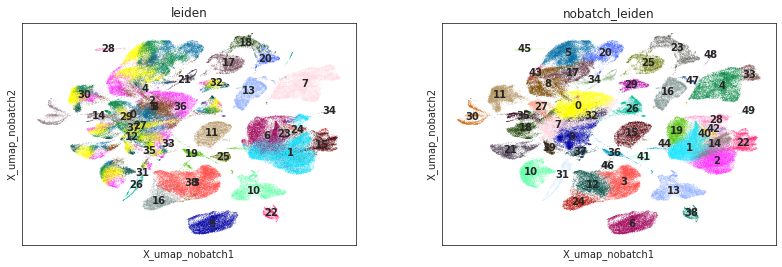

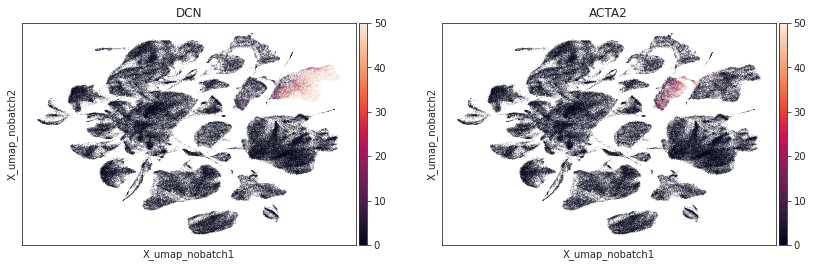

In [3]:
sc.pl.embedding(adata, basis='X_umap_nobatch', color=['leiden', 'nobatch_leiden',], legend_loc='on data')
sc.pl.embedding(adata, basis='X_umap_nobatch', color=['DCN', 'ACTA2'], vmax=50)

In [4]:
adata = adata[adata.obs.doublet_score<0.2]
adata = adata[adata.obs.percent_mito<0.1]

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [5]:
adata = adata[adata.obs.leiden.isin(["13"])]

In [58]:
A = sc.AnnData(adata.X, var=adata.var, obs=adata.obs)
A.raw = A
# del adata
# gc.collect()

In [ ]:
A = pipeline.michi_kallisto_recipe(A,  harmony_correction='samplename',  harmony_clusters=10)
pipeline.differential_expression_michi_kallisto_recipe(A, 'leiden')

In [61]:
# A.write_h5ad('/home/mstrasse/TB4/cellTypeProportions/myofibro_processed.h5ad')

# Analysis

In [2]:
A = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/myofibro_processed.h5ad')

# fixing some diagnosis
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict
A = fix_diagnosis(A)
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)

df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample_diagnosis' as categorical


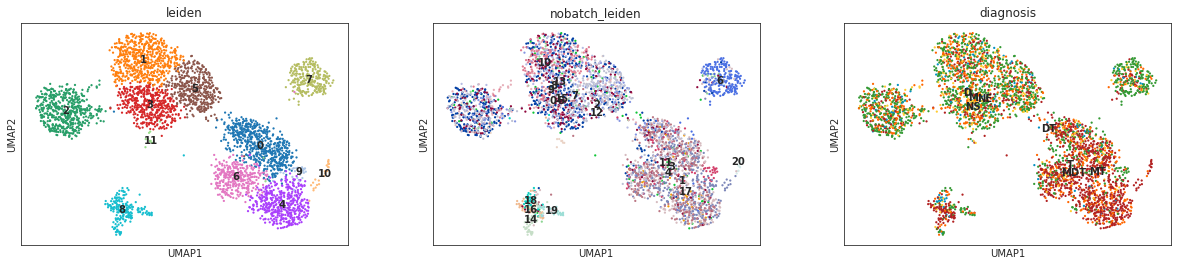

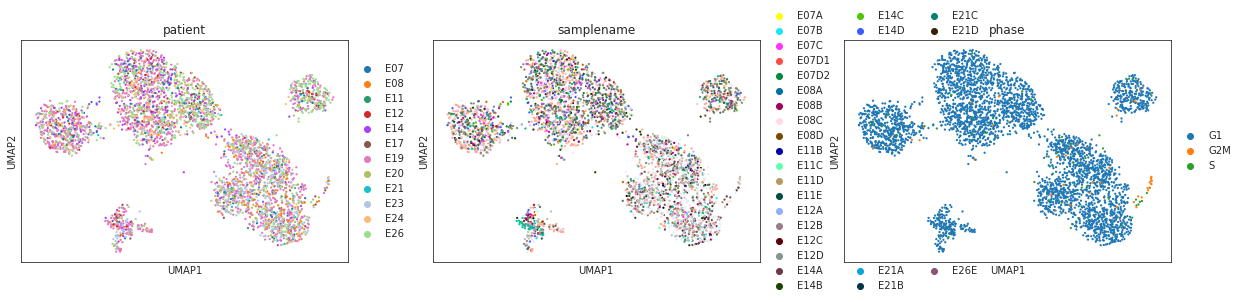

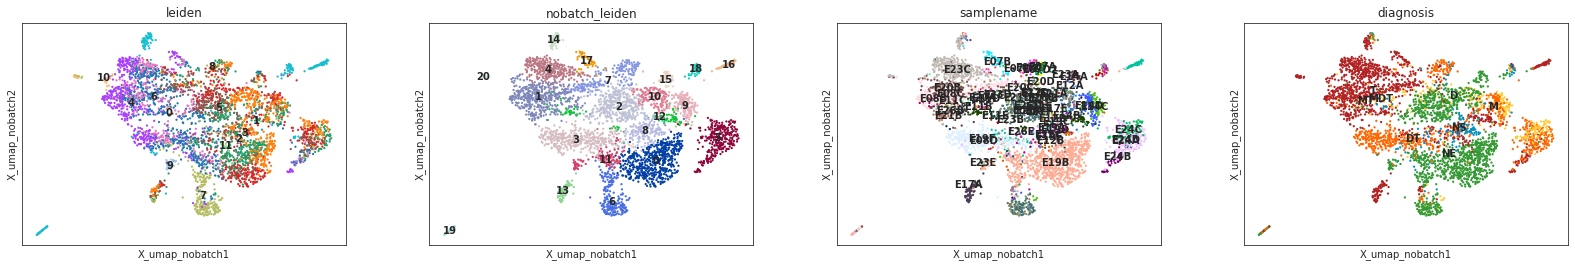

In [3]:
sc.pl.umap(A, color=['leiden', 'nobatch_leiden', 'diagnosis'], legend_loc='on data', size=20)
sc.pl.umap(A, color=['patient', 'samplename', 'phase'], size=20)

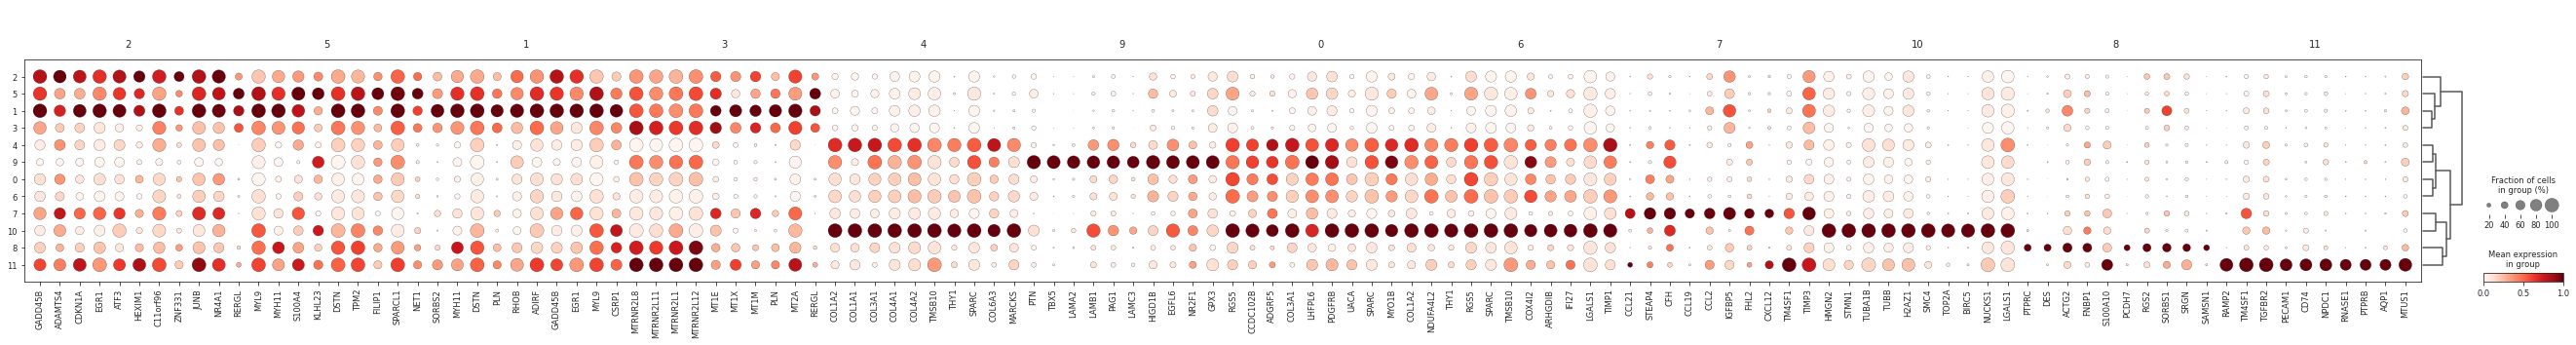

In [5]:
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var', n_genes=10)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


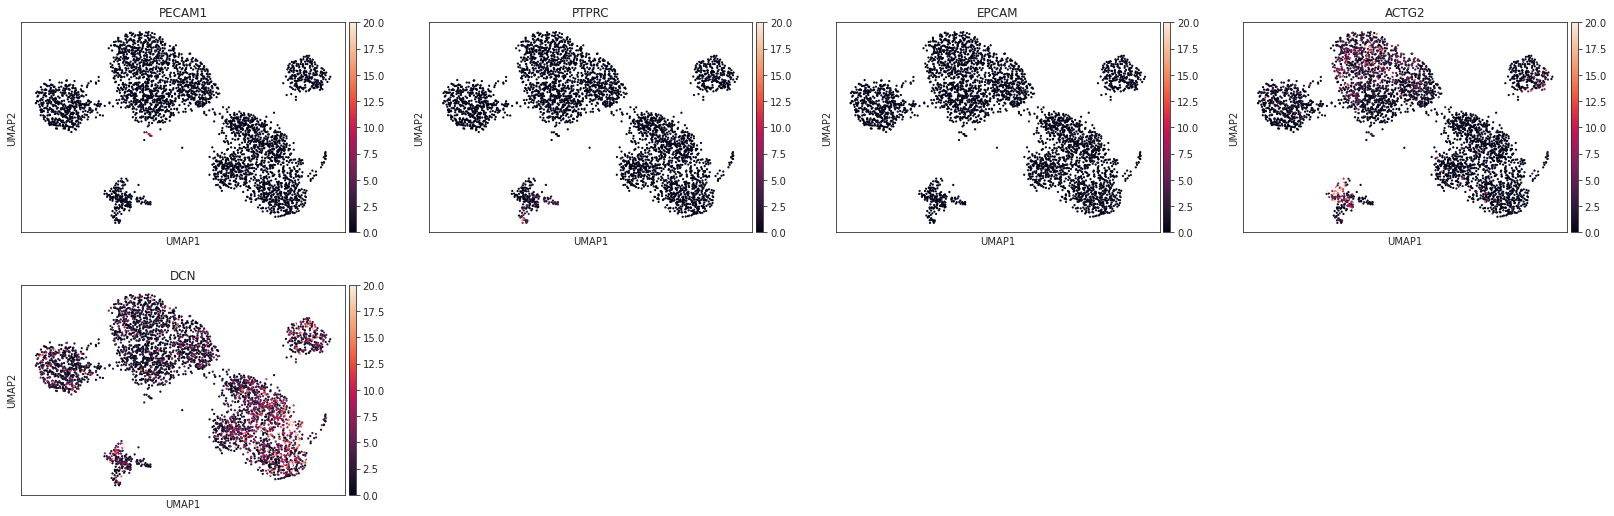

ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 


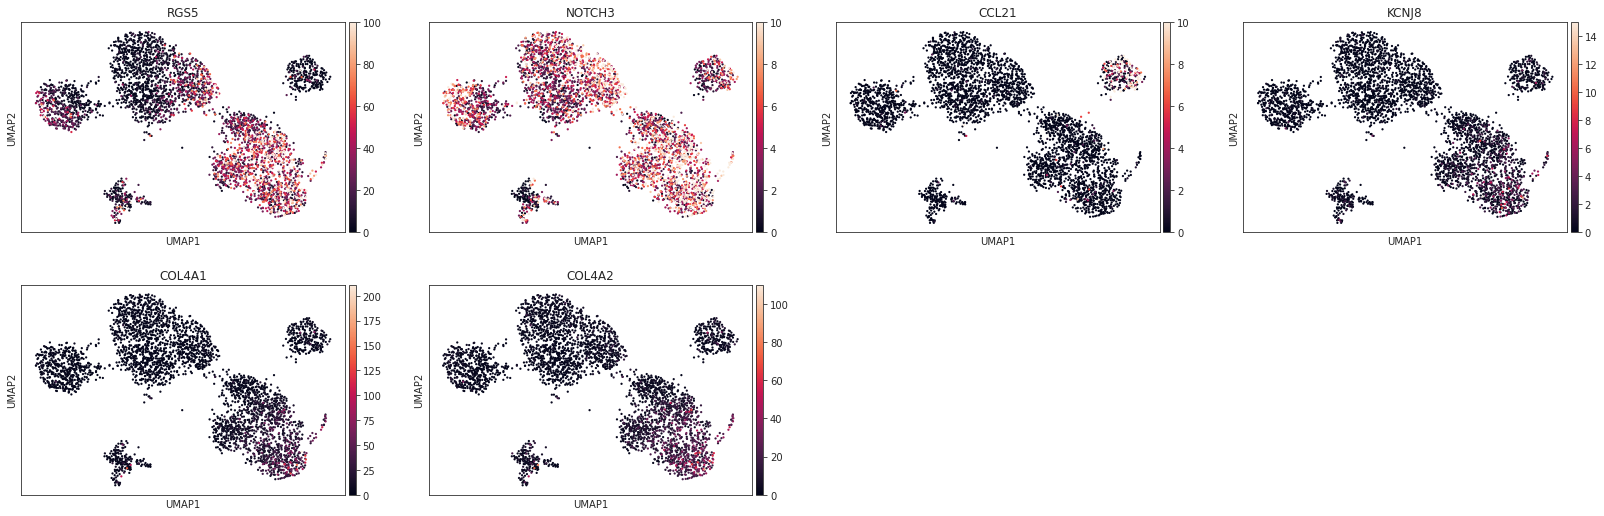

In [6]:
sc.pl.umap(A, color=['PECAM1', 'PTPRC', 'EPCAM', 'ACTG2', 'DCN'], legend_loc='on data', size=20, vmax=20 )#vmax=[100,10,10])
sc.pl.umap(A, color=['RGS5', 'NOTCH3', 'CCL21', 'KCNJ8','COL4A1','COL4A2'], legend_loc='on data', size=20, vmax=[100,10,10])

### Remove doublets

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_diagnosis' as categorical


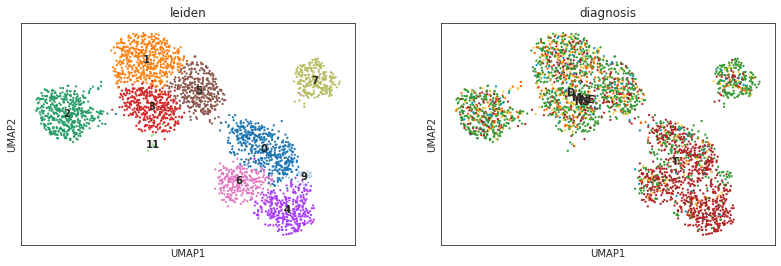

In [4]:
doublets = ['8']
A = A[~A.obs.leiden.isin(doublets)]

A = A[A.obs.diagnosis.isin(['NE', 'NS', 'M','D','T'])]
# remove divinding
A = A[~A.obs.leiden.isin(['10'])]
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

## recluster

In [5]:
if 'leiden_backup' not in A.obs.columns:
    A.obs['leiden_backup'] = A.obs.leiden
sc.tl.leiden(A, resolution=0.7)
del A.uns['leiden_colors']
pipeline.differential_expression_michi_kallisto_recipe(A, groupby='leiden')

11/26/2022 11:01:43 PM doing csr->csc
11/26/2022 11:01:43 PM done csr->csc
11/26/2022 11:01:57 PM doing csc->csr
11/26/2022 11:01:57 PM done csc->csr
11/26/2022 11:01:57 PM Filtering DE
11/26/2022 11:01:58 PM Done Filtering DE


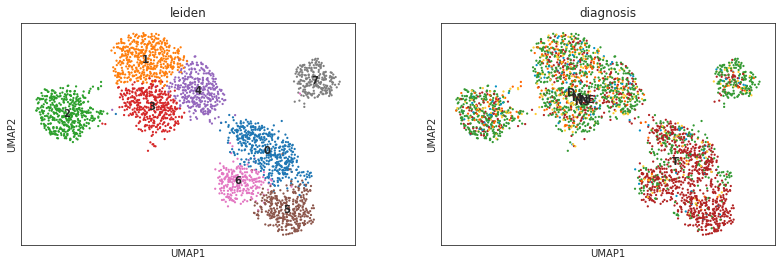

In [6]:
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

# CEll type annotation

- Cluster 0/4/6 have pericyte characteristics (COL4A1, KCNJ8), see here https://www.nature.com/articles/s41467-022-30633-9

- Cluster 1/3/6: TAGLN, MYH11, CNN1, LMOD1 are chartacteristic for VSMC (vascular smooth musle)

Both pericytes and VSMC surround the endothelium of the blood vessel
- Pericytes: on small capilaries
- VSMC: bigger blood vessels

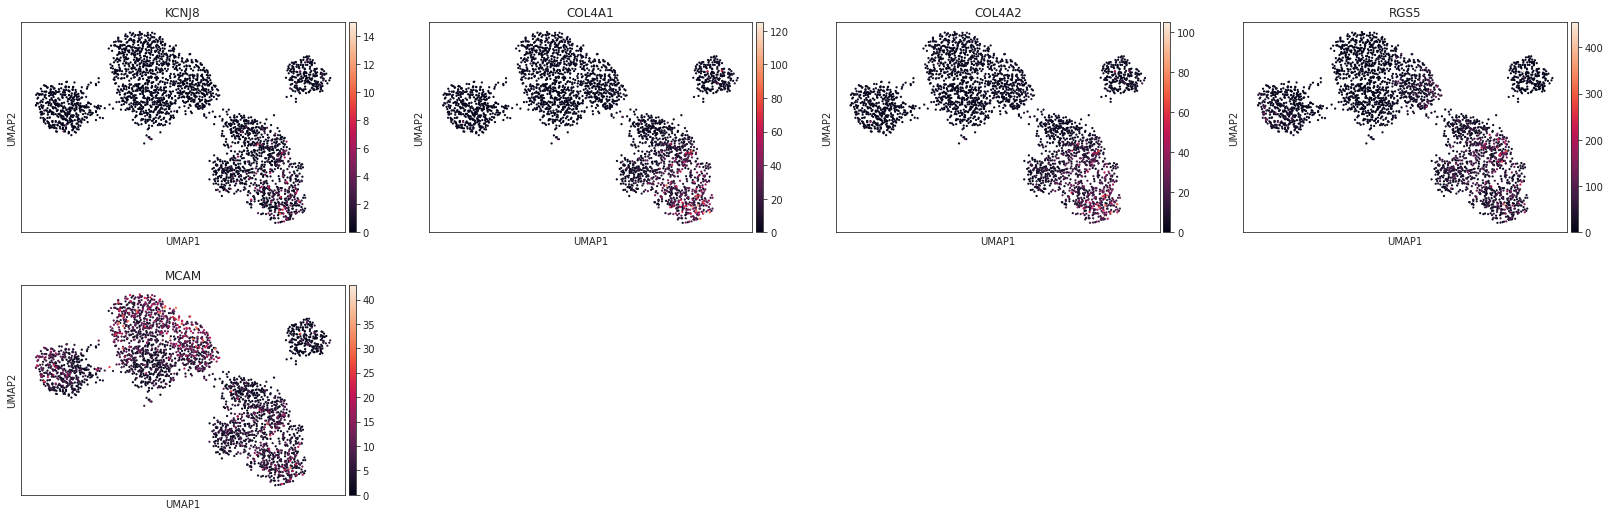

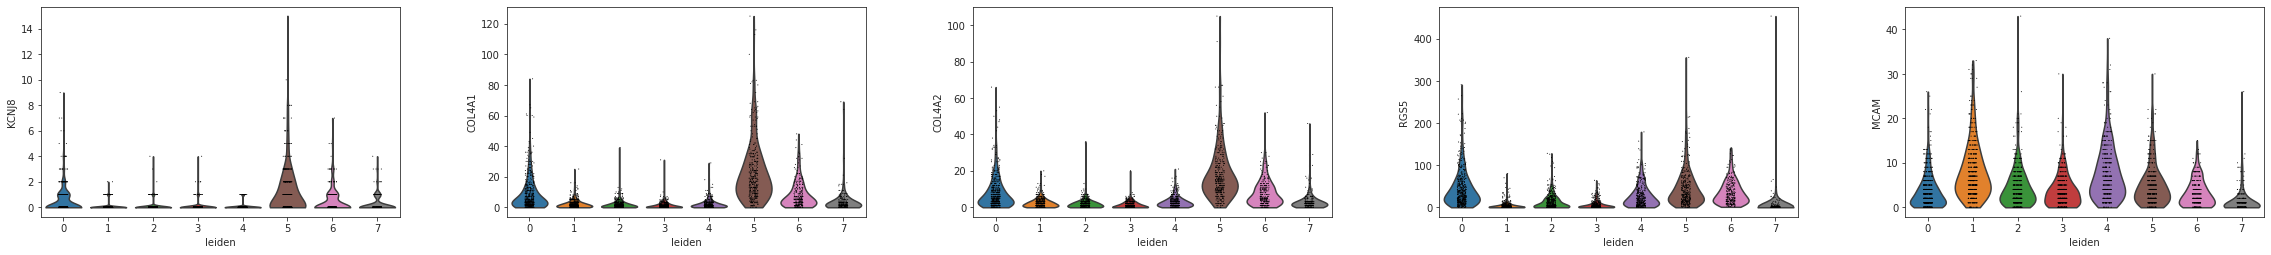

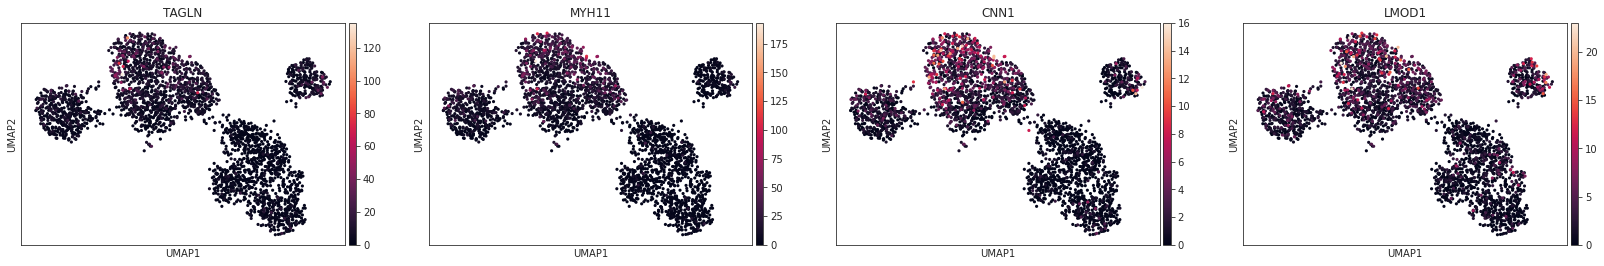

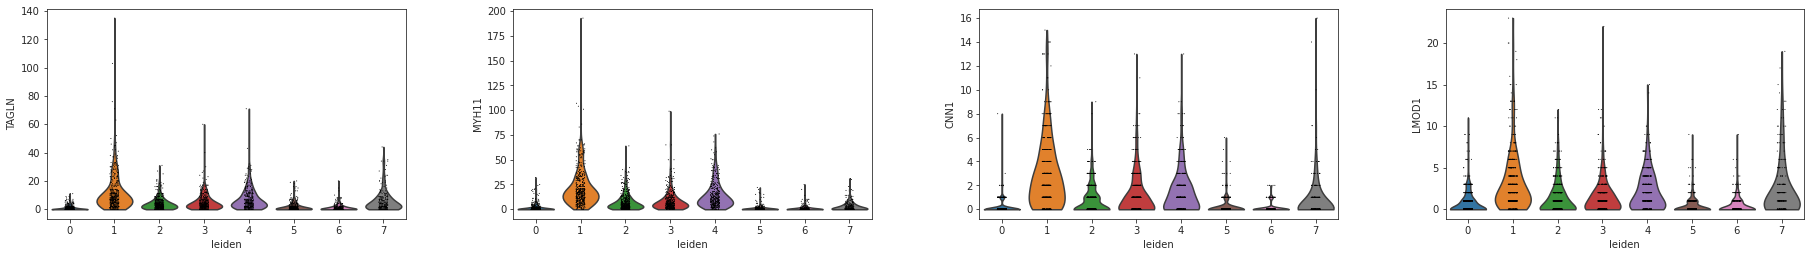

In [10]:
sc.pl.umap(A, color=['KCNJ8','COL4A1','COL4A2', 'RGS5', 'MCAM'], legend_loc='on data', size=20, )
sc.pl.violin(A, keys=['KCNJ8','COL4A1','COL4A2', 'RGS5', 'MCAM'], groupby='leiden')

sc.pl.umap(A, color=['TAGLN', 'MYH11', 'CNN1', 'LMOD1'], legend_loc='on data')
sc.pl.violin(A, keys=['TAGLN', 'MYH11', 'CNN1', 'LMOD1'], groupby='leiden')

# SCCODA

In [8]:
# mkdir /tmp/proportions/MyoFibroblast_proportions

In [9]:
plotfolder = '/tmp/proportions/MyoFibroblast_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [10]:
A = sc.read_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/myofibro_processed.h5ad')
# fixing some diagnosis
from crukiopy_release.datatools import fix_diagnosis, diagnosis_fix_dict
A = fix_diagnosis(A)
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)

df_meta = read_metadata()

# again fix diagnosis in those samples
df_meta = df_meta[df_meta.samplename.isin(A.obs.samplename.unique())].set_index('samplename').sort_values('diagnosis')
for s, d in diagnosis_fix_dict.items():
    df_meta.loc[s, 'diagnosis'] = d

In [11]:
data_scanpy_1 = dat.from_scanpy(
    A,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_df=df_meta[df_meta.index.isin(A.obs.samplename.unique())]
)
print(data_scanpy_1)

AnnData object with n_obs × n_vars = 49 × 8
    obs: 'foldername', 'patient', 'sequencer', 'tissue', 'flowcell', 'procedure', 'diagnosis', 'treatment', 'phantompurger_folder', 'cruk_sample', 'atlas_sample', 'R2length', 'gender'
    var: 'n_cells'


In [12]:
cluster_order = A.obs.leiden.cat.categories
cluster_order = ['1','3','4','2','7','0','5','6']

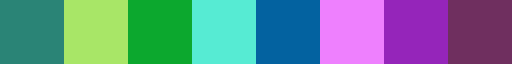

In [13]:
# reorder a little, to givve the pericytes a different hue
from crukiopy_release.colormaps import cmap_subtypes, ListedColormap
cmap_subtypes = np.array(cmap_subtypes.colors)[[1,2,3, 0, 7, 10,11,12]]
cmap_subtypes = ListedColormap(
    cmap_subtypes
)
cmap_subtypes

In [14]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

In [14]:
# note: need to write the full 35k genes! .to_adata() neatly pulls that out of .raw and applies any other attributes from teh original adata
# B = A.raw.to_adata()
# B.uns = A.uns
# B.obsm = A.obsm
# B.obsp= A.obsp
# B.write_h5ad('/home/mstrasse/TB4/cellTypeProportions/scCODA_ready/myofibro_processed.h5ad')

In [15]:
set_matplotlib_formats('png')

In [16]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


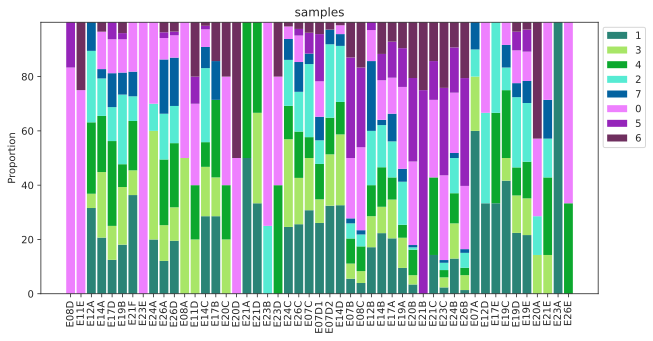

In [17]:
order = []
_snames = data_scanpy_1.obs.index.unique()
for d in diagnosis_ordered:
    order.extend(sorted(df_meta.query('samplename in @_snames and diagnosis==@d').index))

set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="samples", figsize=(10,5), level_order=order, cmap=cmap_subtypes)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Myofibroblasts_proportions_per_sample.svg')

In [21]:
set_matplotlib_formats('png')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample_diagnosis' as categorical


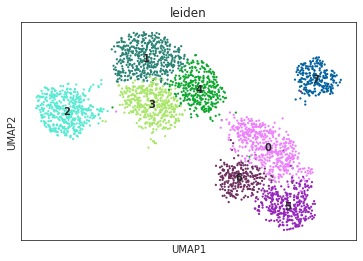

In [22]:
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Myofibroblasts_umap.svg')
plt.savefig(f'{plotfolder}/Myofibroblasts_umap.png')

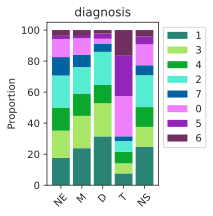

In [61]:
set_matplotlib_formats('svg')
fig = viz.stacked_barplot(data_scanpy_1[:, cluster_order], feature_name="diagnosis", level_order=diagnosis_ordered, cmap=cmap_subtypes, figsize=(2,3))
fig.figure.savefig(f'{plotfolder}/Myofibroblast_proportions_per_diagnosis.svg')

In [22]:
set_matplotlib_formats('png')

In [40]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 3 x 2 in image.
/home/mstrasse/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /tmp/proportions/MyoFibroblast_proportions//Myofibroblast_proportions_per_cluster.svg


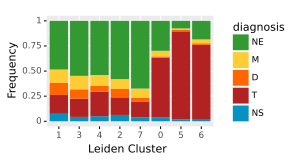

<ggplot: (8746530087649)>

In [41]:
set_matplotlib_formats('svg')
p= pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis)+ pn.labs(x='Leiden Cluster', y='Frequency')
p.save(f'{plotfolder}/Myofibroblast_proportions_per_cluster.svg')
p

In [25]:
set_matplotlib_formats('png')

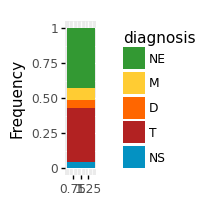

<ggplot: (8731111133065)>

In [26]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'index': 'diagnosis','diagnosis': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

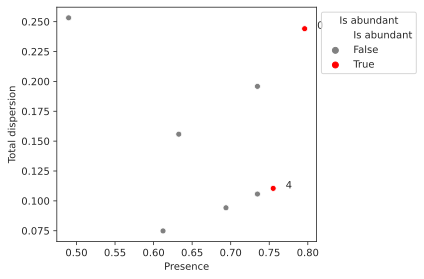

In [42]:
viz.rel_abundance_dispersion_plot(
    data=data_scanpy_1,
    abundant_threshold=0.75)
plt.show()

In [43]:
model_salm = mod.CompositionalAnalysis(data_scanpy_1, formula="C(diagnosis, Treatment('NE')) + procedure + patient", reference_cell_type="4")
# Run MCMC
sim_results = model_salm.sample_hmc(num_results=5*20000)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 100000/100000 [14:49<00:00, 112.45it/s]


MCMC sampling finished. (931.097 sec)
Acceptance rate: 47.4%


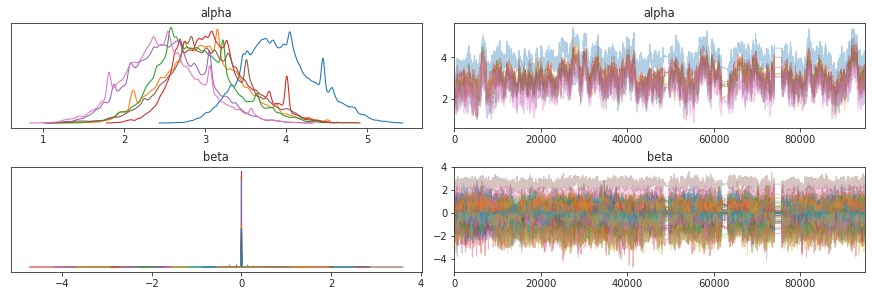

In [44]:
import arviz as az
set_matplotlib_formats('png')
az.plot_trace(
    sim_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": sim_results.posterior.coords["cell_type_nb"]},
)
plt.show()

In [45]:
scCODA_result = sim_results.effect_df
scCODA_result[sim_results.effect_df['Final Parameter'] != 0]

Final Parameter  HDI 3%  \
Covariate                          Cell Type                            
C(diagnosis, Treatment('NE'))[T.T] 0                 1.192889   0.837   
                                   5                 2.484019   1.986   
                                   6                 1.616058   1.163   
procedure[T.resection]             0                -1.155470  -1.711   
                                   5                -0.851358  -1.493   
                                   6                -1.205385  -1.851   
patient[T.E12]                     7                 0.966453  -0.009   
patient[T.E14]                     5                -0.908195  -1.683   
patient[T.E17]                     0                -1.669687  -2.433   
                                   5                -1.554830  -2.410   
                                   6                -1.709897  -2.621   
patient[T.E24]                     3                 0.619132  -0.014   
patient[T.E26]                     1                -0.524044  -1.007   

                                              HDI 97%     SD  \
Covariate                          Cell Type                   
C(diagnosis, Treatment('NE'))[T.T] 0            1.540  0.188   
                                   5            3.004  0.265   
                                   6            2.067  0.241   
procedure[T.resection]             0           -0.612  0.299   
                                   5           -0.279  0.400   
                                   6           -0.521  0.399   
patient[T.E12]                     7            1.833  0.569   
patient[T.E14]                     5            0.048  0.484   
patient[T.E17]                     0           -0.817  0.432   
                                   5           -0.681  0.493   
                                   6           -0.816  0.596   
patient[T.E24]                     3            1.172  0.373   
patient[T.E26]                     1            0.020  0.310   

                                              Inclusion probability  \
Covariate                          Cell Type                          
C(diagnosis, Treatment('NE'))[T.T] 0                       1.000000   
                                   5                       1.000000   
                                   6                       1.000000   
procedure[T.resection]             0                       1.000000   
                                   5                       0.894053   
                                   6                       0.973811   
patient[T.E12]                     7                       0.874000   
patient[T.E14]                     5                       0.951379   
patient[T.E17]                     0                       1.000000   
                                   5                       0.986232   
                                   6                       0.952221   
patient[T.E24]                     3                       0.878158   
patient[T.E26]                     1                       0.871779   

                                              Expected Sample  \
Covariate                          Cell Type                    
C(diagnosis, Treatment('NE'))[T.T] 0                20.104708   
                                   5                18.823090   
                                   6                12.417698   
procedure[T.resection]             0                 8.053770   
                                   5                 2.810193   
                                   6                 3.099454   
patient[T.E12]                     7                 9.960756   
patient[T.E14]                     5                 1.909525   
patient[T.E17]                     0                 5.311718   
                                   5                 1.533836   
                                   6                 2.064124   
patient[T.E24]                     3                13.229755   
patient[T.E26

In [46]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace({
    "C(diagnosis, Treatment('NE'))[T.D]": 'D',
    "C(diagnosis, Treatment('NE'))[T.M]": 'M',
    "C(diagnosis, Treatment('NE'))[T.T]": 'T',
    "C(diagnosis, Treatment('NE'))[T.NS]": 'NS',
    "procedure[T.resection]": 'resection'
    }),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

Text(6.0, 0.5, '')

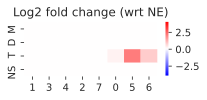

In [47]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)

In [ ]:
fig.savefig(f'{plotfolder}/Myofibroblasts_scCODA.svg')

In [48]:
set_matplotlib_formats('png')

In [116]:
# fig, ax = plt.subplots(figsize=(14, 2))
# sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')

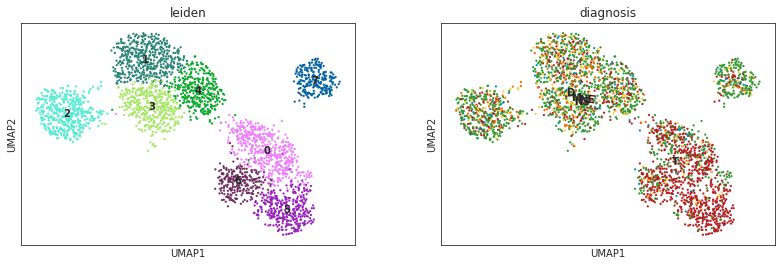

In [117]:
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

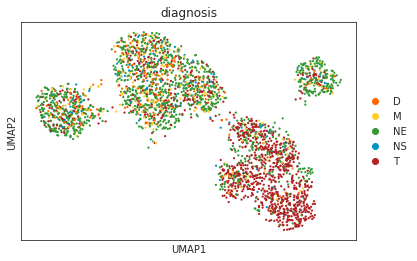

In [118]:
sc.pl.umap(A, color=['diagnosis'],  size=20)

# Marker

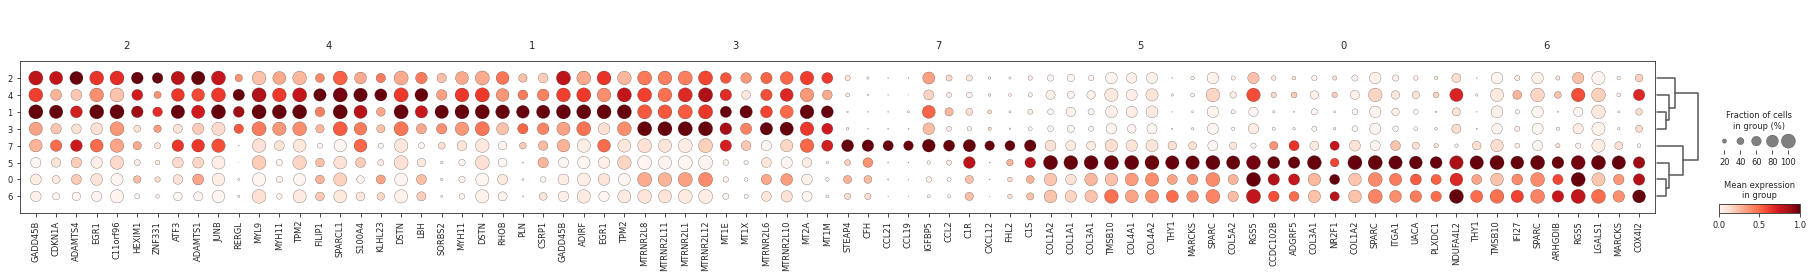

In [23]:
sc.tl.dendrogram(A, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


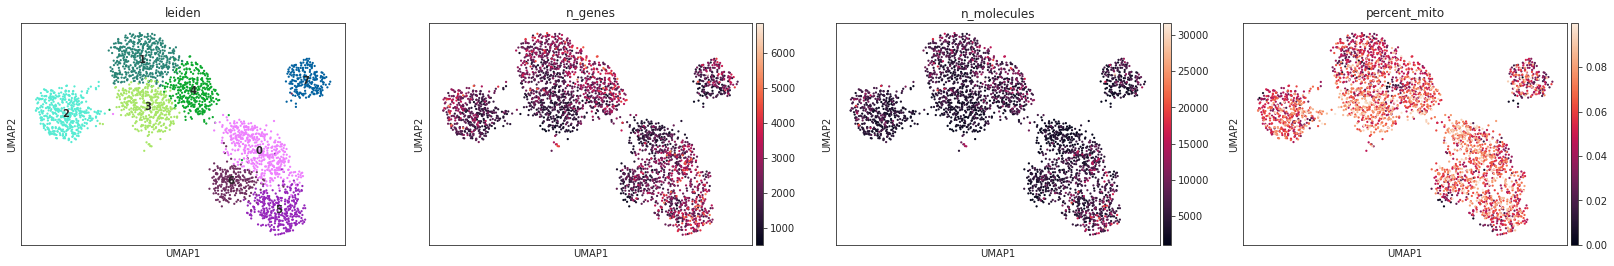

In [24]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden', 'n_genes','n_molecules', 'percent_mito'], legend_loc='on data', size=20)

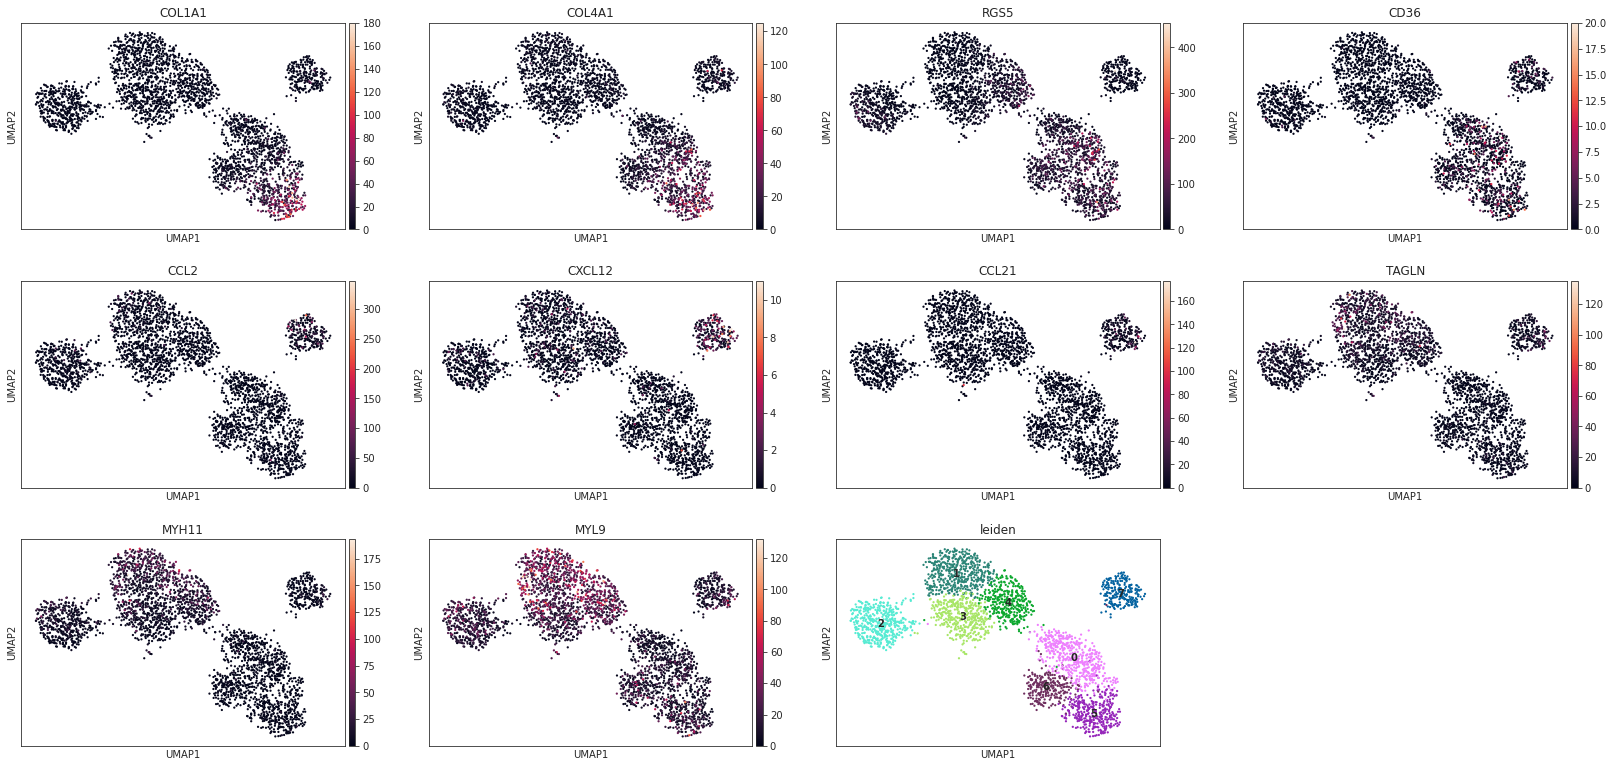

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


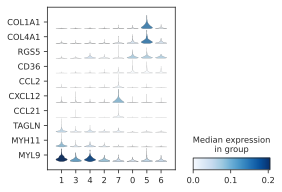

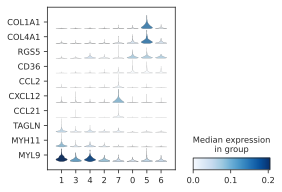

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


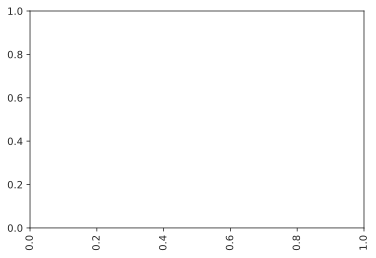

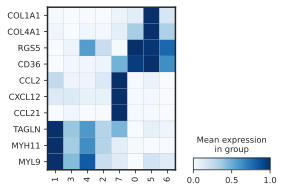

In [26]:
genes =['COL1A1', 'COL4A1', 'RGS5', 'CD36',
        'CCL2', 'CXCL12','CCL21',
       'TAGLN', 'MYH11', 'MYL9']
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')
sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, use_raw=False,show=False, #order=cluster_order
                figsize=(4,3))
plt.savefig(f'{plotfolder}/Myofibroblast_markers.svg')


sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, use_raw=False, #order=cluster_order
                figsize=(4,3))
plt.xticks(rotation=90);

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/MyoF_markers_matrix.svg')